## Chapter 5 - Differentiable optimization

In [6]:
import cvxpy as cp
import numpy as np

m,n = 50,10
A = np.random.randn(m,n)
b = np.random.randn(m)
x = cp.Variable(n)
lam = 0.1

f = cp.sum_squares(A@x - b) + lam*cp.norm1(x)
cons = [x >= 0]
cp.Problem(cp.Minimize(f), cons).solve(verbose=True, eps_abs=1e-8, eps_rel=1e-8)
print(np.round(x.value,5))

                                     CVXPY                                     
                                    v1.1.15                                    
(CVXPY) Oct 02 06:59:00 PM: Your problem has 10 variables, 1 constraints, and 0 parameters.
(CVXPY) Oct 02 06:59:00 PM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Oct 02 06:59:00 PM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Oct 02 06:59:00 PM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Oct 02 06:59:00 PM: Compiling problem (target solver=OSQP).
(CVXPY) Oct 02 06:59:00 PM: Reduction chain: CvxAttr2Constr -> Qp2SymbolicQp -> QpMatrixStuffing

In [7]:
print(np.round(cons[0].dual_value, 5))

[23.96264  0.       0.       0.       5.30653  1.00936 -0.       0.
  3.17491  0.     ]


In [8]:
import torch
import torch.nn as nn
import torch.autograd as autograd
from itertools import accumulate

class OptLayer(nn.Module):
    def __init__(self, variables, parameters, objective, inequalities, equalities, **cvxpy_opts):
        super().__init__()
        self.variables = variables
        self.parameters = parameters
        self.objective = objective
        self.inequalities = inequalities
        self.equalities = equalities
        self.cvxpy_opts = cvxpy_opts
        
        # create the cvxpy problem with objective, inequalities, equalities
        self.cp_inequalities = [ineq(*variables, *parameters) <= 0 for ineq in inequalities]
        self.cp_equalities = [eq(*variables, *parameters) == 0 for eq in equalities]
        self.problem = cp.Problem(cp.Minimize(objective(*variables, *parameters)), 
                                  self.cp_inequalities + self.cp_equalities)
        
    def forward(self, *batch_params):
        out, J = [], []
        # solve over minibatch by just iterating
        for batch in range(batch_params[0].shape[0]):
            # solve the optimization problem and extract solution + dual variables
            params = [p[batch] for p in batch_params]
            with torch.no_grad():
                for i,p in enumerate(self.parameters):
                    p.value = params[i].double().numpy()
                self.problem.solve(**self.cvxpy_opts)
                z = [torch.tensor(v.value).type_as(params[0]) for v in self.variables]
                lam = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_inequalities]
                nu = [torch.tensor(c.dual_value).type_as(params[0]) for c in self.cp_equalities]

            # convenience routines to "flatten" and "unflatten" (z,lam,nu)
            def vec(z, lam, nu):
                return torch.cat([a.view(-1) for b in [z,lam,nu] for a in b])

            def mat(x):
                sz = [0] + list(accumulate([a.numel() for b in [z,lam,nu] for a in b]))
                val = [x[a:b] for a,b in zip(sz, sz[1:])]
                return ([val[i].view_as(z[i]) for i in range(len(z))],
                        [val[i+len(z)].view_as(lam[i]) for i in range(len(lam))],
                        [val[i+len(z)+len(lam)].view_as(nu[i]) for i in range(len(nu))])

            # computes the KKT residual
            def kkt(z, lam, nu, *params):
                g = [ineq(*z, *params) for ineq in self.inequalities]
                dnu = [eq(*z, *params) for eq in self.equalities]
                L = (self.objective(*z, *params) + 
                     sum((u*v).sum() for u,v in zip(lam,g)) + sum((u*v).sum() for u,v in zip(nu,dnu)))
                dz = autograd.grad(L, z, create_graph=True)
                dlam = [lam[i]*g[i] for i in range(len(lam))]
                return dz, dlam, dnu

            # compute residuals and re-engage autograd tape
            y = vec(z, lam, nu)
            y = y - vec(*kkt([z_.clone().detach().requires_grad_() for z_ in z], lam, nu, *params))

            # compute jacobian and backward hook
            J.append(autograd.functional.jacobian(lambda x: vec(*kkt(*mat(x), *params)), y))
            y.register_hook(lambda grad,b=batch : torch.solve(grad[:,None], J[b].transpose(0,1))[0][:,0])
            
            out.append(mat(y)[0])
        out = [torch.stack(o, dim=0) for o in zip(*out)]
        return out[0] if len(out) == 1 else tuple(out)

In [10]:
# create a differentiable quadratic program
n,m,p = 10,4,5
z = cp.Variable(n)
Psqrt = cp.Parameter((n,n))
q = cp.Parameter(n)
G = cp.Parameter((m,n))
h = cp.Parameter(m)
A = cp.Parameter((p,n))
b = cp.Parameter()

def f_(z,Psqrt,q,G,h,A,b):
    return 0.5*cp.sum_squares(Psqrt @ z) + q@z if isinstance(z, cp.Variable) else 0.5*torch.sum((Psqrt @ z)**2) + q@z
def g_(z,Psqrt,q,G,h,A,b):
    return G@z - h
def h_(z,Psqrt,q,G,h,A,b):
    return A@z - b

layer = OptLayer(variables = [z], parameters = [Psqrt, q, G, h, A, b], 
                 objective = f_, inequalities = [g_], equalities=[h_],
                 solver=cp.OSQP, eps_abs = 1e-8, eps_rel = 1e-8)

In [11]:
# verify the gradient
torch_params = [torch.randn(2,*p.shape, dtype=torch.double).requires_grad_() for p in layer.parameters]
autograd.gradcheck(lambda *x: layer(*x).sum(), tuple(torch_params), eps=1e-4, atol=1e-3, check_undefined_grad=False)

/net/pulsar/home/koes/mtr22/local/lib/python3.6/site-packages/ipykernel_launcher.py:63: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)


True

In [12]:
# sigmoid as optimization layer
z = cp.Variable(1)
x = cp.Parameter(1)
def f_(z,x):
    if isinstance(z, cp.Variable):
        return -cp.multiply(z,x) - cp.entr(z) - cp.entr(1-z)
    else:
        return -z*x + z*torch.log(z) + (1-z)*torch.log(1-z)

layer = OptLayer([z], [x], f_, [], [])

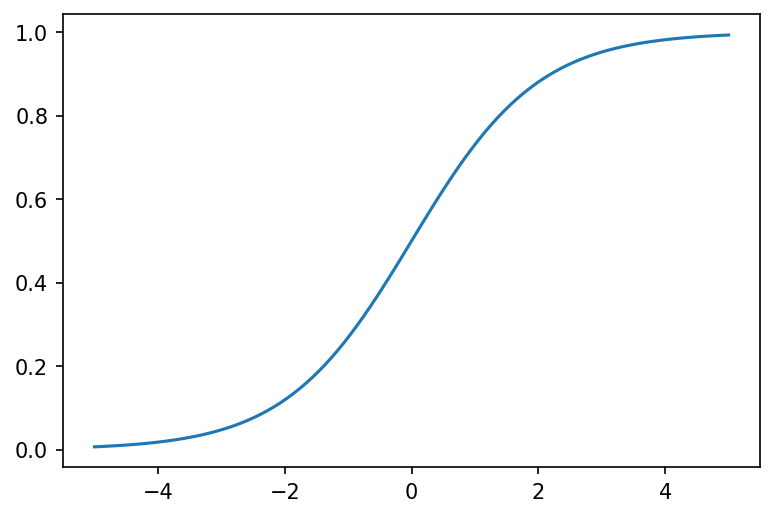

In [13]:
import matplotlib.pyplot as plt
%matplotlib inline

x = torch.linspace(-5,5,100).requires_grad_()
y = layer(x[:,None])[:,0]
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), y.detach().numpy())

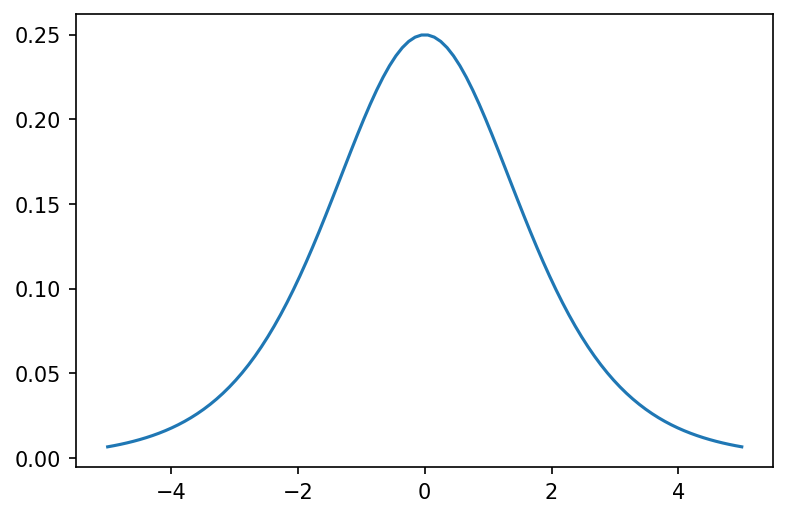

In [14]:
y.sum().backward()
plt.figure(dpi=150)
plt.plot(x.detach().numpy(), x.grad.detach().numpy())

In [17]:
# softmax as optimization layer
z = cp.Variable(10)
x = cp.Parameter(10)

f_ = lambda z,x: -z@x - cp.sum(cp.entr(z)) if isinstance(z, cp.Variable) else -z@x + z@torch.log(z)
h_ = lambda z,x: cp.sum(z) - 1 if isinstance(z, cp.Variable) else z.sum() - 1

layer = OptLayer([z], [x], f_, [], [h_])

In [18]:
import torch.nn.functional as F
x = torch.randn(20,10).requires_grad_()
y = layer(x)
y0 = nn.Softmax(dim=1)(x)
print("Mean absolute error of forward pass:", (y - y0).abs().mean().item())

Mean absolute error of forward pass: 4.864507445745403e-07


In [19]:
r = torch.randn(*y0.shape)
(y*r).sum().backward()
print("Mean absolute error of backward pass:", (x.grad - autograd.grad((y0*r).sum(), x)[0]).abs().mean().item())

Mean absolute error of backward pass: 3.922142468582024e-07


In [20]:
# sparsemax nonlinearity
z = cp.Variable(10)
x = cp.Parameter(10)

f_ = lambda z,x : cp.sum_squares(z - x) if isinstance(z, cp.Variable) else torch.sum((x-z)**2)
g_ = lambda z,x : -z
h_ = lambda z,x: cp.sum(z) - 1 if isinstance(z, cp.Variable) else z.sum() - 1

layer = OptLayer([z], [x], f_, [g_], [h_])

In [21]:
x = torch.randn(3,10).requires_grad_()
y = layer(x)
print(np.round(y.detach().numpy(),4))

[[-0.     -0.     -0.     -0.     -0.     -0.      0.1091  0.0803 -0.
   0.8106]
 [-0.     -0.      0.804  -0.     -0.     -0.     -0.      0.      0.196
  -0.    ]
 [-0.     -0.     -0.     -0.      0.3892  0.0913 -0.      0.5195 -0.
  -0.    ]]


In [22]:
class PolytopeProjection(nn.Module):
    def __init__(self, n, m):
        super().__init__()
        self.G = nn.Parameter(torch.randn(m,n))
        self.h = nn.Parameter(torch.ones(m))
        
        obj = lambda z,x,G,h : cp.sum_squares(z - x) if isinstance(z, cp.Variable) else torch.sum((x-z)**2)
        ineq = lambda z,x,G,h : G@z - h
        self.layer = OptLayer([cp.Variable(n)], [cp.Parameter(n), cp.Parameter((m,n)), cp.Parameter(m)],
                              obj, [ineq], [])
    
    def forward(self, x):
        return self.layer(x, self.G.expand(x.shape[0], *self.G.shape), self.h.expand(x.shape[0], *self.h.shape))

(-1.0997856438159943,
 1.0991059124469758,
 -1.0989542067050935,
 1.0999502003192902)

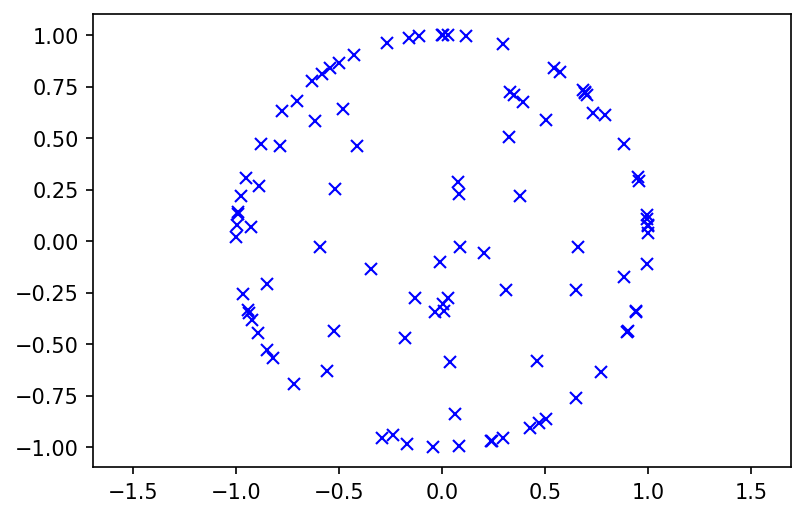

In [23]:
# create some data
p = 100
X = torch.randn(p, 2)
Y = X / X.norm(dim=1).clamp(min=1)[:,None]
plt.figure(dpi=150)
plt.plot(Y[:,0], Y[:,1],'bx')
plt.axis("equal")

In [24]:
torch.manual_seed(0)
layer = PolytopeProjection(2, 20)

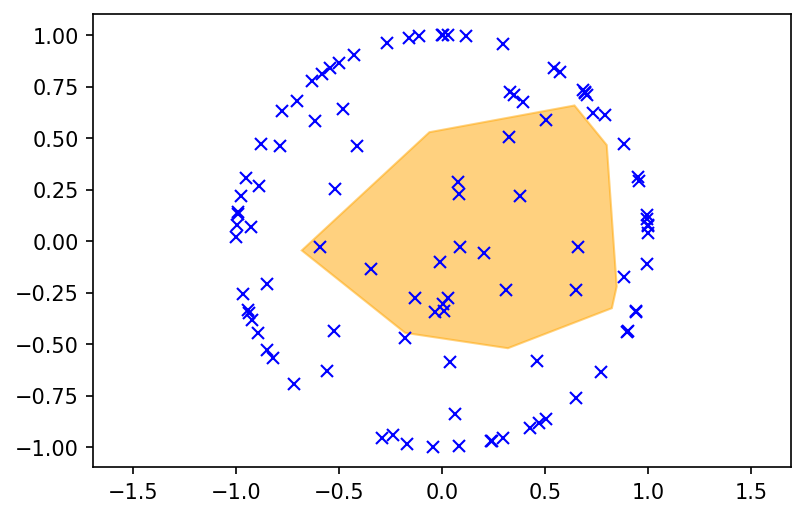

In [25]:
# randomly initialized polytope
from scipy.spatial import HalfspaceIntersection
from matplotlib.patches import Polygon

def plot_polytope(G, h, X):
    hs = HalfspaceIntersection(np.hstack((G.detach(),  -h[:,None].detach())), np.array([0.,0.]))
    pts = hs.intersections - hs.interior_point
    pts = pts[np.argsort(np.arctan2(pts[:,1],pts[:,0])),:] + hs.interior_point
    plt.fill(pts[:,0], pts[:,1], color="orange", alpha=0.5)
    plt.plot(X[:,0], X[:,1], 'bx')
    
plt.figure(dpi=150)
plot_polytope(layer.G, layer.h, Y)
plt.axis('equal');

In [26]:
# optimize polytope with adam
import torch.optim as optim
opt = optim.Adam(layer.parameters(), lr=1e-1)
for i in range(40):
    if i == 20:
        opt.param_groups[0]["lr"] = 1e-2
    loss = nn.MSELoss()(layer(X), Y)
    opt.zero_grad()
    loss.backward()
    opt.step()

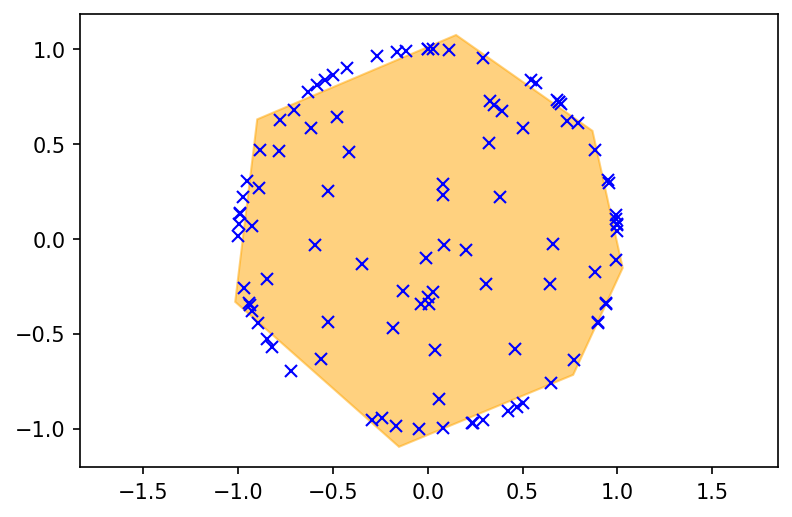

In [28]:
plt.figure(dpi=150)
plot_polytope(layer.G, layer.h, Y)
plt.axis('equal');